# Autoencoders in SciKeras

Autencoders are an approach to use nearual networks to distill data into it's most important features, thereby compressing the data. We will be following the [Keras tutorial](https://blog.keras.io/building-autoencoders-in-keras.html) on the topic, which goes much more in depth and breadth than we will here. You are highly encouraged to check out that tutorial if you want to learn about autoencoders in the general sense.

## Table of contents

* [1. Setup](#1.-Setup)
* [2. Data](#2.-Data)
* [3. Define Keras Model](#3.-Define-Keras-Model)
* [4. Training](#4.-Training)
* [5. Explore Results](#5.-Explore-Results)

## 1. Setup

In [1]:
try:
    import scikeras
except ImportError:
    !python -m pip install scikeras

Silence TensorFlow logging to keep output succinct.

In [2]:
import warnings
from tensorflow import get_logger
get_logger().setLevel('ERROR')
warnings.filterwarnings("ignore", message="Setting the random state for TF")

In [3]:
import numpy as np
from scikeras.wrappers import KerasClassifier, KerasRegressor
from tensorflow import keras

## 2. Data

We load the dataset from the Keras tutorial. The dataset consists of images of cats and dogs.

In [4]:
from tensorflow.keras.datasets import mnist
import numpy as np


(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

    8192/11490434 [..............................] - ETA: 0s

 3973120/11490434 [=========>....................] - ETA: 0s

11493376/11490434 [==============================] - 0s 0us/step


(60000, 784)
(10000, 784)


## 3. Define Keras Model

We will be defining a very simple autencoder. We define _three_ model building methods:

1. One to build a full end-to-end autoencoder.
2. One to create a model that includes only the encoder portion.
3. One that creates a model that includes only the decoder portion.

The only variable we give our model is the encoding dimensions, which will be a hyperparemter of our final transformer.

In [5]:
from tensorflow import keras


def get_fit_model(encoding_dim: int) -> keras.Model:
    """Get an autoencoder.

    This autoencoder compresses a 28x28 image (784 pixels) down to a feature of length
    `encoding_dim`, and tries to reconstruct the input image from that vector.
    """
    input_img = keras.Input(shape=(784,), name="input")
    encoded = keras.layers.Dense(encoding_dim, activation='relu', name="encoded")(input_img)
    decoded = keras.layers.Dense(784, activation='sigmoid', name="output")(encoded)
    autoencoder_model = keras.Model(input_img, decoded)
    return autoencoder_model

def get_tf_model(fit_model: keras.Model) -> keras.Model:
    """Get an encoder model.

    We do this by extracting the encoding layer from the fitted autoencoder model.
    """
    return keras.Model(fit_model.get_layer("input").input, fit_model.get_layer("encoded").output)

def get_inverse_tf_model(fit_model: keras.Model, encoding_dim: int) -> keras.Model:
    """Get an deencoder model.

    We do this by extracting the deencoding layer from the fitted autoencoder model
    and adding a new Keras input layer.
    """
    encoded_input = keras.Input(shape=(encoding_dim,))
    output = fit_model.get_layer("output")(encoded_input)
    return keras.Model(encoded_input, output)

Next we create a class that that will enable the `transform` and `fit_transform` methods, as well as integrating all three of our models into a single estimator.

In [6]:
from sklearn.base import TransformerMixin, clone
from scikeras.wrappers import BaseWrapper


class KerasTransformer(BaseWrapper, TransformerMixin):
    """A class that enables transform and fit_transform.
    """

    def __init__(self, *args, tf_est: BaseWrapper = None, inv_tf_est: BaseWrapper = None, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.tf_est = tf_est
        self.inv_tf_est = inv_tf_est


    def fit(self, X, sample_weight=None):
        super().fit(X=X, y=X, sample_weight=sample_weight)
        self.tf_est_ = clone(self.tf_est)
        self.inv_tf_est_ = clone(self.inv_tf_est)
        self.tf_est_.set_params(fit_model=self.model_)
        self.inv_tf_est_.set_params(fit_model=self.model_, encoding_dim=self.encoding_dim)
        X = self.feature_encoder_.transform(X)
        self.tf_est_.initialize(X=X)
        X_tf = self.tf_est_.predict(X=X)
        self.inv_tf_est_.initialize(X_tf)
        return self

    def transform(self, X):
        X = self.feature_encoder_.transform(X)
        X_tf = self.tf_est_.predict(X)
        return X_tf
    
    def inverse_transform(self, X_tf):
        X = self.inv_tf_est_.predict(X_tf)
        X = self.feature_encoder_.inverse_transform(X)
        return X

Next, we wrap the Keras Model with Scikeras. Note that for our encoder/decoder estimators, we do not need to provide a loss function since no training will be done. We do however need to have the `fit_model` and `encoding_dim` so that these will be settable by `BaseWrapper.set_params`.

In [7]:
tf_est = BaseWrapper(model=get_tf_model, fit_model=None, verbose=0)
inv_tf_est = BaseWrapper(model=get_inverse_tf_model, fit_model=None, encoding_dim=None, verbose=0)
autoencoder = KerasTransformer(model=get_fit_model, tf_est=tf_est, inv_tf_est=inv_tf_est, loss="binary_crossentropy", encoding_dim=32, epochs=5)

## 4. Training

To train the model, we pass the input images as both the features and the target. This will train the layers to compress the data as accurately as possible between the encoder and decoder. Note that we only pass the `X` parameter, since we defined the mapping `y=X` in `KerasTransformer.fit` above.

In [8]:
_ = autoencoder.fit(X=x_train)

Epoch 1/5


   1/1875 [..............................] - ETA: 12:44 - loss: 0.6961

  29/1875 [..............................] - ETA: 3s - loss: 0.5563   

  59/1875 [..............................] - ETA: 3s - loss: 0.4716

  90/1875 [>.............................] - ETA: 3s - loss: 0.4261

 122/1875 [>.............................] - ETA: 2s - loss: 0.3967

 150/1875 [=>............................] - ETA: 2s - loss: 0.3780

 179/1875 [=>............................] - ETA: 2s - loss: 0.3628

 204/1875 [==>...........................] - ETA: 2s - loss: 0.3520

 233/1875 [==>...........................] - ETA: 2s - loss: 0.3412

 261/1875 [===>..........................] - ETA: 2s - loss: 0.3323

 291/1875 [===>..........................] - ETA: 2s - loss: 0.3239

 319/1875 [====>.........................] - ETA: 2s - loss: 0.3168

 347/1875 [====>.........................] - ETA: 2s - loss: 0.3105

 373/1875 [====>.........................] - ETA: 2s - loss: 0.3051

 402/1875 [=====>........................] - ETA: 2s - loss: 0.2996

 431/1875 [=====>........................] - ETA: 2s - loss: 0.2945

 450/1875 [======>.......................] - ETA: 2s - loss: 0.2914

 479/1875 [======>.......................] - ETA: 2s - loss: 0.2870

 514/1875 [=======>......................] - ETA: 2s - loss: 0.2820

 547/1875 [=======>......................] - ETA: 2s - loss: 0.2777

 575/1875 [========>.....................] - ETA: 2s - loss: 0.2742

 603/1875 [========>.....................] - ETA: 2s - loss: 0.2710

 633/1875 [=========>....................] - ETA: 2s - loss: 0.2677

 667/1875 [=========>....................] - ETA: 2s - loss: 0.2642

 704/1875 [==========>...................] - ETA: 2s - loss: 0.2606

 742/1875 [==========>...................] - ETA: 1s - loss: 0.2572

 782/1875 [===========>..................] - ETA: 1s - loss: 0.2538

 814/1875 [============>.................] - ETA: 1s - loss: 0.2512

 847/1875 [============>.................] - ETA: 1s - loss: 0.2487

 883/1875 [=============>................] - ETA: 1s - loss: 0.2460

 922/1875 [=============>................] - ETA: 1s - loss: 0.2433

 952/1875 [==============>...............] - ETA: 1s - loss: 0.2413

 983/1875 [==============>...............] - ETA: 1s - loss: 0.2393

1015/1875 [===============>..............] - ETA: 1s - loss: 0.2374

1052/1875 [===============>..............] - ETA: 1s - loss: 0.2352

1088/1875 [================>.............] - ETA: 1s - loss: 0.2331

1114/1875 [================>.............] - ETA: 1s - loss: 0.2317

1145/1875 [=================>............] - ETA: 1s - loss: 0.2301

1175/1875 [=================>............] - ETA: 1s - loss: 0.2285

1212/1875 [==================>...........] - ETA: 1s - loss: 0.2267

1246/1875 [==================>...........] - ETA: 1s - loss: 0.2251

1278/1875 [===================>..........] - ETA: 0s - loss: 0.2236

1313/1875 [====================>.........] - ETA: 0s - loss: 0.2220

1344/1875 [====================>.........] - ETA: 0s - loss: 0.2207

1374/1875 [====================>.........] - ETA: 0s - loss: 0.2194

1398/1875 [=====================>........] - ETA: 0s - loss: 0.2184

1421/1875 [=====================>........] - ETA: 0s - loss: 0.2175

1449/1875 [======================>.......] - ETA: 0s - loss: 0.2164

1478/1875 [======================>.......] - ETA: 0s - loss: 0.2153

1507/1875 [=======================>......] - ETA: 0s - loss: 0.2142

1529/1875 [=======================>......] - ETA: 0s - loss: 0.2133

1552/1875 [=======================>......] - ETA: 0s - loss: 0.2125

1584/1875 [========================>.....] - ETA: 0s - loss: 0.2114

1610/1875 [========================>.....] - ETA: 0s - loss: 0.2105

1637/1875 [=========================>....] - ETA: 0s - loss: 0.2096

1664/1875 [=========================>....] - ETA: 0s - loss: 0.2087

1685/1875 [=========================>....] - ETA: 0s - loss: 0.2080

1711/1875 [==========================>...] - ETA: 0s - loss: 0.2071

1728/1875 [==========================>...] - ETA: 0s - loss: 0.2066

1751/1875 [===========================>..] - ETA: 0s - loss: 0.2059

1777/1875 [===========================>..] - ETA: 0s - loss: 0.2051

1802/1875 [===========================>..] - ETA: 0s - loss: 0.2043

1829/1875 [============================>.] - ETA: 0s - loss: 0.2035

1856/1875 [============================>.] - ETA: 0s - loss: 0.2027

1875/1875 [==============================] - 4s 2ms/step - loss: 0.2022


Epoch 2/5
   1/1875 [..............................] - ETA: 5s - loss: 0.1127

  27/1875 [..............................] - ETA: 3s - loss: 0.1117

  55/1875 [..............................] - ETA: 3s - loss: 0.1111

  86/1875 [>.............................] - ETA: 3s - loss: 0.1107

 114/1875 [>.............................] - ETA: 3s - loss: 0.1103

 137/1875 [=>............................] - ETA: 3s - loss: 0.1101

 164/1875 [=>............................] - ETA: 3s - loss: 0.1100

 195/1875 [==>...........................] - ETA: 3s - loss: 0.1098

 226/1875 [==>...........................] - ETA: 3s - loss: 0.1096

 258/1875 [===>..........................] - ETA: 2s - loss: 0.1095

 288/1875 [===>..........................] - ETA: 2s - loss: 0.1093

 313/1875 [====>.........................] - ETA: 2s - loss: 0.1092

 341/1875 [====>.........................] - ETA: 2s - loss: 0.1091

 372/1875 [====>.........................] - ETA: 2s - loss: 0.1090

 402/1875 [=====>........................] - ETA: 2s - loss: 0.1089

 430/1875 [=====>........................] - ETA: 2s - loss: 0.1088

 456/1875 [======>.......................] - ETA: 2s - loss: 0.1088

 488/1875 [======>.......................] - ETA: 2s - loss: 0.1087

 521/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 551/1875 [=======>......................] - ETA: 2s - loss: 0.1085

 582/1875 [========>.....................] - ETA: 2s - loss: 0.1084

 613/1875 [========>.....................] - ETA: 2s - loss: 0.1083

 645/1875 [=========>....................] - ETA: 2s - loss: 0.1082

 675/1875 [=========>....................] - ETA: 2s - loss: 0.1081

 701/1875 [==========>...................] - ETA: 2s - loss: 0.1080

 731/1875 [==========>...................] - ETA: 2s - loss: 0.1079

 763/1875 [===========>..................] - ETA: 1s - loss: 0.1078

 794/1875 [===========>..................] - ETA: 1s - loss: 0.1078

 827/1875 [============>.................] - ETA: 1s - loss: 0.1077

 858/1875 [============>.................] - ETA: 1s - loss: 0.1076

 889/1875 [=============>................] - ETA: 1s - loss: 0.1075

 917/1875 [=============>................] - ETA: 1s - loss: 0.1074

 946/1875 [==============>...............] - ETA: 1s - loss: 0.1073

 977/1875 [==============>...............] - ETA: 1s - loss: 0.1073

1003/1875 [===============>..............] - ETA: 1s - loss: 0.1072

1034/1875 [===============>..............] - ETA: 1s - loss: 0.1071

1065/1875 [================>.............] - ETA: 1s - loss: 0.1071

1097/1875 [================>.............] - ETA: 1s - loss: 0.1070

1128/1875 [=================>............] - ETA: 1s - loss: 0.1069

1160/1875 [=================>............] - ETA: 1s - loss: 0.1068

1189/1875 [==================>...........] - ETA: 1s - loss: 0.1068

1220/1875 [==================>...........] - ETA: 1s - loss: 0.1067

1251/1875 [===================>..........] - ETA: 1s - loss: 0.1066

1283/1875 [===================>..........] - ETA: 1s - loss: 0.1066

1314/1875 [====================>.........] - ETA: 0s - loss: 0.1065

1346/1875 [====================>.........] - ETA: 0s - loss: 0.1064

1378/1875 [=====================>........] - ETA: 0s - loss: 0.1064

1408/1875 [=====================>........] - ETA: 0s - loss: 0.1063

1438/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1469/1875 [======================>.......] - ETA: 0s - loss: 0.1062

1500/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1527/1875 [=======================>......] - ETA: 0s - loss: 0.1061

1558/1875 [=======================>......] - ETA: 0s - loss: 0.1060

1588/1875 [========================>.....] - ETA: 0s - loss: 0.1060

1619/1875 [========================>.....] - ETA: 0s - loss: 0.1059

1649/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1680/1875 [=========================>....] - ETA: 0s - loss: 0.1058

1710/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1742/1875 [==========================>...] - ETA: 0s - loss: 0.1057

1772/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1803/1875 [===========================>..] - ETA: 0s - loss: 0.1056

1834/1875 [============================>.] - ETA: 0s - loss: 0.1055

1864/1875 [============================>.] - ETA: 0s - loss: 0.1055

1875/1875 [==============================] - 3s 2ms/step - loss: 0.1055


Epoch 3/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0912

  32/1875 [..............................] - ETA: 3s - loss: 0.0971

  63/1875 [>.............................] - ETA: 2s - loss: 0.0970

  94/1875 [>.............................] - ETA: 2s - loss: 0.0971

 125/1875 [=>............................] - ETA: 2s - loss: 0.0972

 157/1875 [=>............................] - ETA: 2s - loss: 0.0974

 187/1875 [=>............................] - ETA: 2s - loss: 0.0975

 217/1875 [==>...........................] - ETA: 2s - loss: 0.0976

 245/1875 [==>...........................] - ETA: 2s - loss: 0.0976

 270/1875 [===>..........................] - ETA: 2s - loss: 0.0976

 300/1875 [===>..........................] - ETA: 2s - loss: 0.0976

 331/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 360/1875 [====>.........................] - ETA: 2s - loss: 0.0976

 392/1875 [=====>........................] - ETA: 2s - loss: 0.0976

 421/1875 [=====>........................] - ETA: 2s - loss: 0.0976

 452/1875 [======>.......................] - ETA: 2s - loss: 0.0976

 483/1875 [======>.......................] - ETA: 2s - loss: 0.0976

 514/1875 [=======>......................] - ETA: 2s - loss: 0.0976

 545/1875 [=======>......................] - ETA: 2s - loss: 0.0976

 574/1875 [========>.....................] - ETA: 2s - loss: 0.0976

 605/1875 [========>.....................] - ETA: 2s - loss: 0.0976

 635/1875 [=========>....................] - ETA: 2s - loss: 0.0976

 662/1875 [=========>....................] - ETA: 2s - loss: 0.0976

 693/1875 [==========>...................] - ETA: 2s - loss: 0.0976

 724/1875 [==========>...................] - ETA: 1s - loss: 0.0976

 753/1875 [===========>..................] - ETA: 1s - loss: 0.0975

 784/1875 [===========>..................] - ETA: 1s - loss: 0.0975

 815/1875 [============>.................] - ETA: 1s - loss: 0.0975

 846/1875 [============>.................] - ETA: 1s - loss: 0.0975

 874/1875 [============>.................] - ETA: 1s - loss: 0.0975

 906/1875 [=============>................] - ETA: 1s - loss: 0.0975

 937/1875 [=============>................] - ETA: 1s - loss: 0.0975

 968/1875 [==============>...............] - ETA: 1s - loss: 0.0975

 999/1875 [==============>...............] - ETA: 1s - loss: 0.0975

1030/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1058/1875 [===============>..............] - ETA: 1s - loss: 0.0975

1083/1875 [================>.............] - ETA: 1s - loss: 0.0975

1114/1875 [================>.............] - ETA: 1s - loss: 0.0975

1144/1875 [=================>............] - ETA: 1s - loss: 0.0975

1175/1875 [=================>............] - ETA: 1s - loss: 0.0975

1206/1875 [==================>...........] - ETA: 1s - loss: 0.0975

1236/1875 [==================>...........] - ETA: 1s - loss: 0.0975

1265/1875 [===================>..........] - ETA: 1s - loss: 0.0975

1295/1875 [===================>..........] - ETA: 0s - loss: 0.0975

1328/1875 [====================>.........] - ETA: 0s - loss: 0.0974

1353/1875 [====================>.........] - ETA: 0s - loss: 0.0974

1381/1875 [=====================>........] - ETA: 0s - loss: 0.0974

1411/1875 [=====================>........] - ETA: 0s - loss: 0.0974

1442/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1472/1875 [======================>.......] - ETA: 0s - loss: 0.0974

1502/1875 [=======================>......] - ETA: 0s - loss: 0.0974

1532/1875 [=======================>......] - ETA: 0s - loss: 0.0974

1564/1875 [========================>.....] - ETA: 0s - loss: 0.0974

1595/1875 [========================>.....] - ETA: 0s - loss: 0.0974

1627/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1658/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1684/1875 [=========================>....] - ETA: 0s - loss: 0.0974

1716/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1748/1875 [==========================>...] - ETA: 0s - loss: 0.0974

1779/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1811/1875 [===========================>..] - ETA: 0s - loss: 0.0974

1843/1875 [============================>.] - ETA: 0s - loss: 0.0974

1872/1875 [============================>.] - ETA: 0s - loss: 0.0973

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0973


Epoch 4/5
   1/1875 [..............................] - ETA: 3s - loss: 0.0924

  31/1875 [..............................] - ETA: 3s - loss: 0.0973

  63/1875 [>.............................] - ETA: 2s - loss: 0.0970

  95/1875 [>.............................] - ETA: 2s - loss: 0.0968

 126/1875 [=>............................] - ETA: 2s - loss: 0.0967

 151/1875 [=>............................] - ETA: 2s - loss: 0.0967

 174/1875 [=>............................] - ETA: 3s - loss: 0.0966

 194/1875 [==>...........................] - ETA: 3s - loss: 0.0966

 215/1875 [==>...........................] - ETA: 3s - loss: 0.0966

 240/1875 [==>...........................] - ETA: 3s - loss: 0.0965

 268/1875 [===>..........................] - ETA: 3s - loss: 0.0965

 297/1875 [===>..........................] - ETA: 3s - loss: 0.0965

 327/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 356/1875 [====>.........................] - ETA: 2s - loss: 0.0964

 384/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 413/1875 [=====>........................] - ETA: 2s - loss: 0.0964

 435/1875 [=====>........................] - ETA: 2s - loss: 0.0963

 462/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 490/1875 [======>.......................] - ETA: 2s - loss: 0.0963

 519/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 545/1875 [=======>......................] - ETA: 2s - loss: 0.0963

 569/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 594/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 617/1875 [========>.....................] - ETA: 2s - loss: 0.0963

 644/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 676/1875 [=========>....................] - ETA: 2s - loss: 0.0963

 708/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 739/1875 [==========>...................] - ETA: 2s - loss: 0.0963

 771/1875 [===========>..................] - ETA: 2s - loss: 0.0963

 803/1875 [===========>..................] - ETA: 1s - loss: 0.0963

 831/1875 [============>.................] - ETA: 1s - loss: 0.0962

 861/1875 [============>.................] - ETA: 1s - loss: 0.0962

 892/1875 [=============>................] - ETA: 1s - loss: 0.0962

 923/1875 [=============>................] - ETA: 1s - loss: 0.0962

 954/1875 [==============>...............] - ETA: 1s - loss: 0.0962

 985/1875 [==============>...............] - ETA: 1s - loss: 0.0962

1016/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1047/1875 [===============>..............] - ETA: 1s - loss: 0.0962

1077/1875 [================>.............] - ETA: 1s - loss: 0.0962

1109/1875 [================>.............] - ETA: 1s - loss: 0.0962

1138/1875 [=================>............] - ETA: 1s - loss: 0.0962

1169/1875 [=================>............] - ETA: 1s - loss: 0.0962

1200/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1232/1875 [==================>...........] - ETA: 1s - loss: 0.0962

1263/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1294/1875 [===================>..........] - ETA: 1s - loss: 0.0962

1324/1875 [====================>.........] - ETA: 0s - loss: 0.0961

1355/1875 [====================>.........] - ETA: 0s - loss: 0.0961

1387/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1418/1875 [=====================>........] - ETA: 0s - loss: 0.0961

1449/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1479/1875 [======================>.......] - ETA: 0s - loss: 0.0961

1511/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1541/1875 [=======================>......] - ETA: 0s - loss: 0.0961

1573/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1604/1875 [========================>.....] - ETA: 0s - loss: 0.0961

1634/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1666/1875 [=========================>....] - ETA: 0s - loss: 0.0961

1698/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0961

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1791/1875 [===========================>..] - ETA: 0s - loss: 0.0961

1823/1875 [============================>.] - ETA: 0s - loss: 0.0961

1855/1875 [============================>.] - ETA: 0s - loss: 0.0961

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0961


Epoch 5/5
   1/1875 [..............................] - ETA: 5s - loss: 0.0910

  34/1875 [..............................] - ETA: 2s - loss: 0.0940

  65/1875 [>.............................] - ETA: 2s - loss: 0.0944

  97/1875 [>.............................] - ETA: 2s - loss: 0.0946

 126/1875 [=>............................] - ETA: 2s - loss: 0.0948

 159/1875 [=>............................] - ETA: 2s - loss: 0.0949

 190/1875 [==>...........................] - ETA: 2s - loss: 0.0950

 223/1875 [==>...........................] - ETA: 2s - loss: 0.0951

 254/1875 [===>..........................] - ETA: 2s - loss: 0.0951

 286/1875 [===>..........................] - ETA: 2s - loss: 0.0952

 317/1875 [====>.........................] - ETA: 2s - loss: 0.0953

 347/1875 [====>.........................] - ETA: 2s - loss: 0.0953

 379/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 411/1875 [=====>........................] - ETA: 2s - loss: 0.0953

 443/1875 [======>.......................] - ETA: 2s - loss: 0.0953

 475/1875 [======>.......................] - ETA: 2s - loss: 0.0954

 506/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 536/1875 [=======>......................] - ETA: 2s - loss: 0.0954

 567/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 597/1875 [========>.....................] - ETA: 2s - loss: 0.0954

 628/1875 [=========>....................] - ETA: 2s - loss: 0.0954

 659/1875 [=========>....................] - ETA: 1s - loss: 0.0954

 689/1875 [==========>...................] - ETA: 1s - loss: 0.0954

 720/1875 [==========>...................] - ETA: 1s - loss: 0.0954

 746/1875 [==========>...................] - ETA: 1s - loss: 0.0955

 777/1875 [===========>..................] - ETA: 1s - loss: 0.0955

 807/1875 [===========>..................] - ETA: 1s - loss: 0.0955

 840/1875 [============>.................] - ETA: 1s - loss: 0.0955

 871/1875 [============>.................] - ETA: 1s - loss: 0.0955

 903/1875 [=============>................] - ETA: 1s - loss: 0.0955

 933/1875 [=============>................] - ETA: 1s - loss: 0.0955

 965/1875 [==============>...............] - ETA: 1s - loss: 0.0954

 996/1875 [==============>...............] - ETA: 1s - loss: 0.0954

1028/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1059/1875 [===============>..............] - ETA: 1s - loss: 0.0954

1091/1875 [================>.............] - ETA: 1s - loss: 0.0954

1121/1875 [================>.............] - ETA: 1s - loss: 0.0954

1152/1875 [=================>............] - ETA: 1s - loss: 0.0954

1185/1875 [=================>............] - ETA: 1s - loss: 0.0954

1213/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1246/1875 [==================>...........] - ETA: 1s - loss: 0.0954

1277/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1308/1875 [===================>..........] - ETA: 0s - loss: 0.0954

1339/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1370/1875 [====================>.........] - ETA: 0s - loss: 0.0954

1400/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1430/1875 [=====================>........] - ETA: 0s - loss: 0.0954

1459/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1490/1875 [======================>.......] - ETA: 0s - loss: 0.0954

1520/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1551/1875 [=======================>......] - ETA: 0s - loss: 0.0954

1581/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1610/1875 [========================>.....] - ETA: 0s - loss: 0.0954

1641/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1671/1875 [=========================>....] - ETA: 0s - loss: 0.0954

1701/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1730/1875 [==========================>...] - ETA: 0s - loss: 0.0954

1761/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1790/1875 [===========================>..] - ETA: 0s - loss: 0.0954

1820/1875 [============================>.] - ETA: 0s - loss: 0.0954

1851/1875 [============================>.] - ETA: 0s - loss: 0.0954

1875/1875 [==============================] - 3s 2ms/step - loss: 0.0954


Next, we round trip the test dataset and explore the performance of the autoencoder.

In [9]:
roundtrip_imgs = autoencoder.inverse_transform(autoencoder.transform(x_test))

## 5. Explore Results

Let's compare our inputs to lossy decoded outputs:

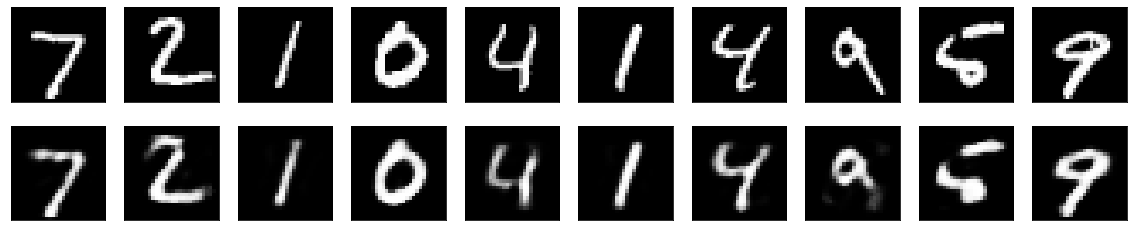

In [10]:
import matplotlib.pyplot as plt


n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(roundtrip_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

What about the compression? Let's check the sizes of the arrays.

In [11]:
encoded_imgs = autoencoder.transform(x_test)
print(f"x_test.shape[1]: {x_test.shape[1]}")
print(f"encoded_imgs.shape[1]: {encoded_imgs.shape[1]}")
cr = round((encoded_imgs.nbytes/x_test.nbytes), 2)
print(f"Compression ratio: 1/{1/cr:.0f}")

x_test.shape[1]: 784
encoded_imgs.shape[1]: 32
Compression ratio: 1/25
